<a href="https://colab.research.google.com/github/akansh12/CS6910_Assignment/blob/main/Part_A_Akansh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
import numpy as np
import torchvision
import os
import torch.nn as nn
from torch.nn import functional as F

In [2]:
import matplotlib.pyplot as plt
import copy
from tqdm.notebook import tqdm

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Qurstion-1

In [3]:
### HELPER FUNCTIONS
def findConv2dOutShape(H_in,W_in,conv,pool=2):
  kernel_size=conv.kernel_size
  stride=conv.stride
  padding=conv.padding
  dilation=conv.dilation

  H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
  W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
  if pool:
    H_out/=pool
    W_out/=pool
  return int(H_out),int(W_out)

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = "cpu"

In [4]:
class conv_net(nn.Module):
  def __init__(self, params): #num_filters, filter_size, activation_functions,dense_neurons,num_outputs
    super(conv_net,self).__init__()
    c_in, h_in, w_in = params["input_shape"]
    num_filters = params["num_filters"]
    filter_size = params["filter_size"]
    self.act_function = params["activation_functions"]
    dense_neurons = params["dense_neurons"]
    num_output = params["num_output"]
    self.dropout = params["dropout"]


    ####Conv layers
    self.conv1 = nn.Conv2d(c_in, num_filters[0], kernel_size=filter_size[0])
    h,w = findConv2dOutShape(h_in, w_in, self.conv1)

    self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=filter_size[1])
    h,w = findConv2dOutShape(h, w, self.conv2)

    self.conv3 = nn.Conv2d(num_filters[1], num_filters[2], kernel_size=filter_size[2])
    h,w = findConv2dOutShape(h, w, self.conv3)


    self.conv4 = nn.Conv2d(num_filters[2], num_filters[3], kernel_size=filter_size[3])
    h,w = findConv2dOutShape(h, w, self.conv4)


    self.conv5 = nn.Conv2d(num_filters[3], num_filters[4], kernel_size=filter_size[4])
    h,w = findConv2dOutShape(h, w, self.conv5)
    #FC layers
    self.num_flatten = h*w*num_filters[4]
    self.fc1 = nn.Linear(self.num_flatten, dense_neurons)
    self.fc2 = nn.Linear(dense_neurons, num_output)

  def forward(self,x):
    x = self.act_function[0](self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = self.act_function[1](self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = self.act_function[2](self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = self.act_function[3](self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = self.act_function[4](self.conv5(x))
    x = F.max_pool2d(x, 2, 2)
    #Flatening the layers
    x = x.view(-1, self.num_flatten)
    
    x = self.act_function[5](self.fc1(x))
    x = F.dropout(x, self.dropout, training= self.training)
    x = self.fc2(x)
    x = F.log_softmax(x, dim=1)
    return x   


In [ ]:
params = {"input_shape": (3,224,224),
          "num_filters": [32,32,64,64,128],
          "filter_size":[3,3,3,3,3],
          "activation_functions": [nn.functional.relu]*6,
          "dense_neurons": 128,
          "num_output":10,
          "dropout": 0.2          
          }

In [6]:
model = conv_net(params)
model.to(device);

1. What is the total number of computations done by your network? (assume m filters in each layer of size k×k and n neurons in the dense layer)

- Ans: 

2. What is the total number of parameters in your network? (assume m filters in each layer of size k×k and n neurons in the dense layer)

- Ans: 

### Question 2

In [18]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import os
path2data_train="/content/drive/MyDrive/inaturalist_12K/train"
path2data_test = "/content/drive/MyDrive/inaturalist_12K/val"

In [19]:
from torchvision.transforms.transforms import RandomRotation
# DATA-Augmentations
train_transforms = transforms.Compose([
transforms.Resize((224,224)),
transforms.RandomRotation((-20,20)),
transforms.RandomHorizontalFlip(p=0.5),
transforms.RandomVerticalFlip(p=0.5),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [20]:
data = datasets.ImageFolder(path2data_train, train_transforms)
test_data = datasets.ImageFolder(path2data_test, test_transforms)

In [21]:
print(data.class_to_idx)

{'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}


In [22]:
### Spiliting the data into train-val
n_val = int(np.floor(0.1 * len(data)))
n_train = len(data) - n_val
train_ds, val_ds = random_split(data, [n_train, n_val])

In [23]:
print("Number of datapoints in train: ", len(train_ds))
print("Number of datapoints in val: ", len(val_ds))
print("Number of datapoints in test: ", len(test_data))

Number of datapoints in train:  9000
Number of datapoints in val:  999
Number of datapoints in test:  2000


In [38]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)
test_dl = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

In [26]:
def accuracy(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

for param in model.parameters():
    param.require_grad = True

from torch import optim

opt = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)
loss_func = nn.NLLLoss()
schedular = optim.lr_scheduler.ReduceLROnPlateau(opt,factor = 0.1,patience = 5)


In [34]:
def training(model, train_params):
  epochs = train_params["num_epochs"]
  train_dl = train_params["train_dl"]
  loss_func = train_params["loss_func"]
  opt = train_params["opt"]
  val_dl = train_params["val_dl"]

  train_loss_hist = []
  valid_loss_hist = []
  train_acc_hist = []
  valid_acc_hist = []
  valid_loss_min = np.Inf

  for i in range(epochs):
      
      train_loss = 0.0
      valid_loss = 0.0
      train_acc = 0.0
      valid_acc = 0.0 
      
      
      model.train()
      
      for images,labels in tqdm(train_dl):
          
          images = images.to(device)
          labels = labels.to(device)
          
          ps = model(images)
          loss = loss_func(ps,labels)
          
          opt.zero_grad()
          loss.backward()
          opt.step()
          
          train_acc += accuracy(ps,labels)
          train_loss += loss.item()
          
      avg_train_acc = train_acc / len(train_dl)
      train_acc_hist.append(avg_train_acc)
      avg_train_loss = train_loss / len(train_dl)
      train_loss_hist.append(avg_train_loss)
          
      model.eval()
      with torch.no_grad():
          
          for images,labels in tqdm(val_dl):
              
              images = images.to(device)
              labels = labels.to(device)
              
              ps = model(images)
              loss = loss_func(ps,labels)
              
              valid_acc += accuracy(ps,labels)
              valid_loss += loss.item()
              
              
          avg_valid_acc = valid_acc / len(val_dl)
          valid_acc_hist.append(avg_valid_acc)
          avg_valid_loss = valid_loss / len(val_dl)
          valid_loss_hist.append(avg_valid_loss)
          
          schedular.step(avg_valid_loss)
          
          if avg_valid_loss <= valid_loss_min:
              print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
              torch.save({
                  'epoch' : i,
                  'model_state_dict' : model.state_dict(),
                  'optimizer_state_dict' : opt.state_dict(),
                  'valid_loss_min' : avg_valid_loss
              },'model.pth')
              
              valid_loss_min = avg_valid_loss
              
      print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
      print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))

  return model.load_state_dict(torch.load("/content/model.pth")['model_state_dict'])


In [39]:
train_params = {"num_epochs": 30,
                "loss_func": loss_func,
                "train_dl":train_dl ,
                "val_dl":val_dl, 
                "test_dl": test_dl,
                "path2weights": "./",
                "opt": opt

               }

In [40]:
training(model, train_params)

100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Validation loss decreased (inf --> 1.932244).   Saving model ...
Epoch : 1 Train Loss : 1.928575 Train Acc : 0.311835
Epoch : 1 Valid Loss : 1.932244 Valid Acc : 0.308644


100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


Validation loss decreased (1.932244 --> 1.910737).   Saving model ...
Epoch : 2 Train Loss : 1.924238 Train Acc : 0.315824
Epoch : 2 Valid Loss : 1.910737 Valid Acc : 0.309270


100%|██████████| 16/16 [00:16<00:00,  1.03s/it]


Validation loss decreased (1.910737 --> 1.904529).   Saving model ...
Epoch : 3 Train Loss : 1.915208 Train Acc : 0.323471
Epoch : 3 Valid Loss : 1.904529 Valid Acc : 0.322316


100%|██████████| 16/16 [00:16<00:00,  1.00s/it]


Epoch : 4 Train Loss : 1.900038 Train Acc : 0.332447
Epoch : 4 Valid Loss : 1.912682 Valid Acc : 0.315129


100%|██████████| 16/16 [00:16<00:00,  1.00s/it]


Validation loss decreased (1.904529 --> 1.893134).   Saving model ...
Epoch : 5 Train Loss : 1.894203 Train Acc : 0.336325
Epoch : 5 Valid Loss : 1.893134 Valid Acc : 0.328801


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Validation loss decreased (1.893134 --> 1.892513).   Saving model ...
Epoch : 6 Train Loss : 1.879281 Train Acc : 0.338320
Epoch : 6 Valid Loss : 1.892513 Valid Acc : 0.323367


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Validation loss decreased (1.892513 --> 1.892054).   Saving model ...
Epoch : 7 Train Loss : 1.872669 Train Acc : 0.340315
Epoch : 7 Valid Loss : 1.892054 Valid Acc : 0.334385


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Validation loss decreased (1.892054 --> 1.886157).   Saving model ...
Epoch : 8 Train Loss : 1.860396 Train Acc : 0.338320
Epoch : 8 Valid Loss : 1.886157 Valid Acc : 0.314779


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Validation loss decreased (1.886157 --> 1.877173).   Saving model ...
Epoch : 9 Train Loss : 1.855098 Train Acc : 0.344415
Epoch : 9 Valid Loss : 1.877173 Valid Acc : 0.334385


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Validation loss decreased (1.877173 --> 1.875711).   Saving model ...
Epoch : 10 Train Loss : 1.849579 Train Acc : 0.351285
Epoch : 10 Valid Loss : 1.875711 Valid Acc : 0.330053


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Validation loss decreased (1.875711 --> 1.873233).   Saving model ...
Epoch : 11 Train Loss : 1.840003 Train Acc : 0.356826
Epoch : 11 Valid Loss : 1.873233 Valid Acc : 0.342748


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


Epoch : 12 Train Loss : 1.825414 Train Acc : 0.358378
Epoch : 12 Valid Loss : 1.880392 Valid Acc : 0.335086


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


Validation loss decreased (1.873233 --> 1.868384).   Saving model ...
Epoch : 13 Train Loss : 1.824506 Train Acc : 0.357713
Epoch : 13 Valid Loss : 1.868384 Valid Acc : 0.340870


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Validation loss decreased (1.868384 --> 1.859544).   Saving model ...
Epoch : 14 Train Loss : 1.820011 Train Acc : 0.363254
Epoch : 14 Valid Loss : 1.859544 Valid Acc : 0.349935


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Validation loss decreased (1.859544 --> 1.856656).   Saving model ...
Epoch : 15 Train Loss : 1.810718 Train Acc : 0.361813
Epoch : 15 Valid Loss : 1.856656 Valid Acc : 0.355794


100%|██████████| 16/16 [00:17<00:00,  1.06s/it]


Validation loss decreased (1.856656 --> 1.847433).   Saving model ...
Epoch : 16 Train Loss : 1.798103 Train Acc : 0.366135
Epoch : 16 Valid Loss : 1.847433 Valid Acc : 0.347631


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Epoch : 17 Train Loss : 1.785314 Train Acc : 0.377438
Epoch : 17 Valid Loss : 1.858132 Valid Acc : 0.349384


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Validation loss decreased (1.847433 --> 1.846104).   Saving model ...
Epoch : 18 Train Loss : 1.787530 Train Acc : 0.373781
Epoch : 18 Valid Loss : 1.846104 Valid Acc : 0.352314


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Validation loss decreased (1.846104 --> 1.843711).   Saving model ...
Epoch : 19 Train Loss : 1.773040 Train Acc : 0.381316
Epoch : 19 Valid Loss : 1.843711 Valid Acc : 0.336964


100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Epoch : 20 Train Loss : 1.767563 Train Acc : 0.378546
Epoch : 20 Valid Loss : 1.861226 Valid Acc : 0.327624


 54%|█████▍    | 152/282 [01:27<01:14,  1.74it/s]


KeyboardInterrupt: ignored

<All keys matched successfully>

### Questiion 4: 

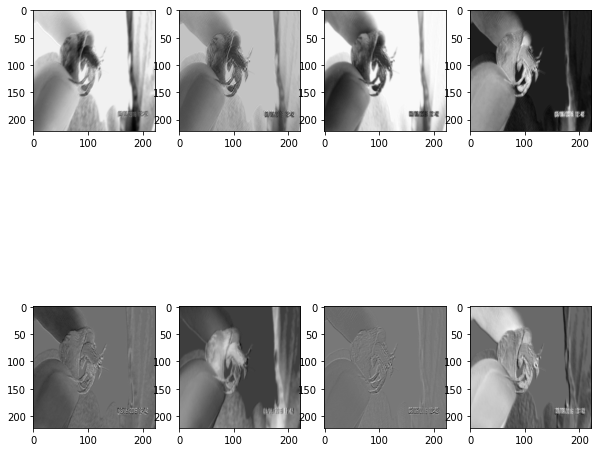

In [42]:
from PIL import Image
def preprocess_image(path2image):
    image =Image.open(path2image)

    preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

    image = preprocess(image)
    image.unsqueeze_(0)

    return image

rnd_image = preprocess_image("/content/drive/MyDrive/inaturalist_12K/val/Animalia/016125d0354a1fc95ed911c85ddec844.jpg")
model = model.to(device)
rnd_image = rnd_image.to(device)

no_of_layers=0
conv_layers=[]

model_children=list(model.children())

for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)


first_layer_output = conv_layers[0](rnd_image)
n_row = 2
n_col = 4

fig, axs = plt.subplots(n_row,n_col, figsize = (10,10))
f_count = 0
for i in range(n_row):
  for j in range(n_col):
    axs[i,j].imshow(first_layer_output[0][f_count].cpu().detach().numpy(), cmap = "gray")
    f_count += 1


### Question 5:


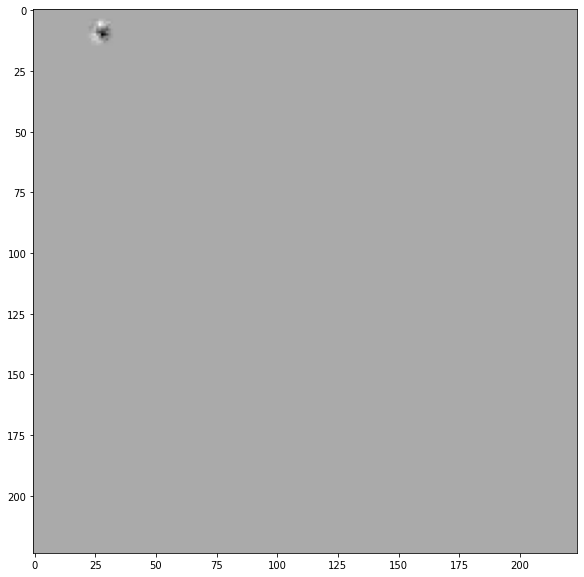

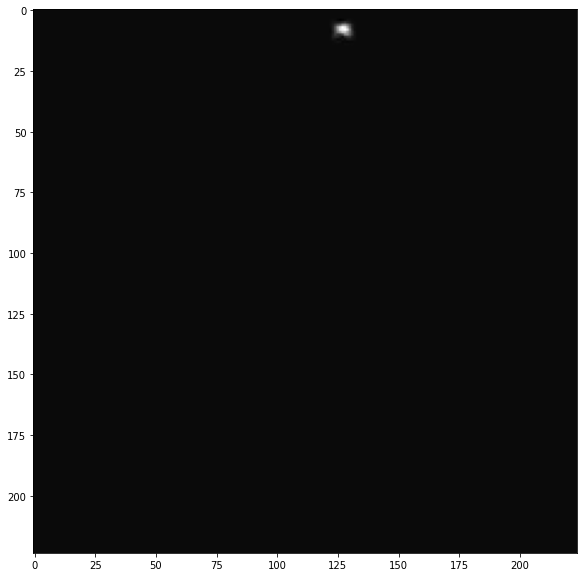

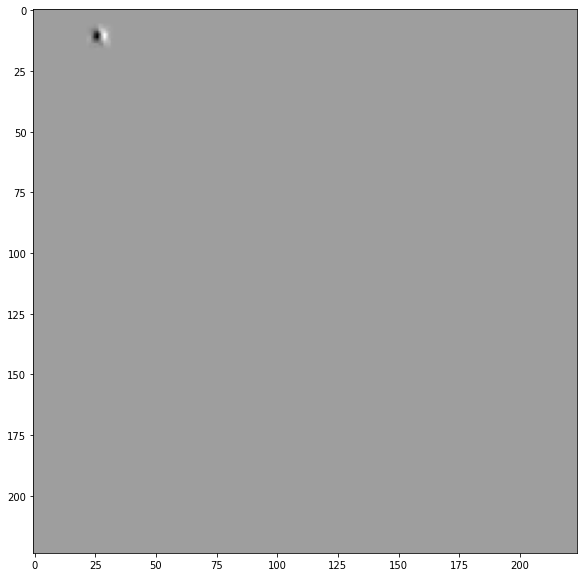

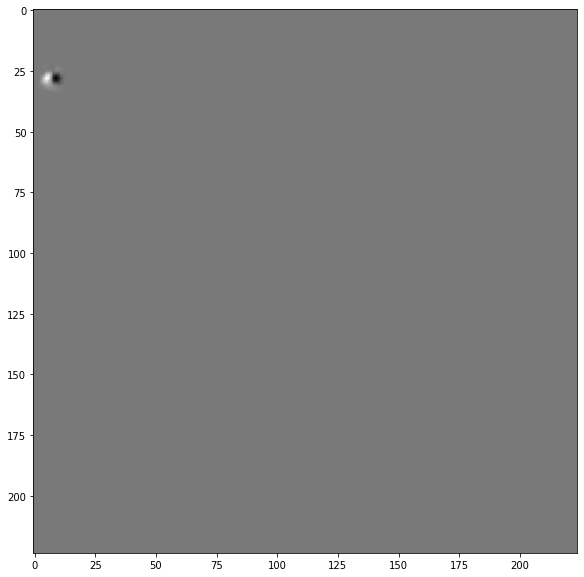

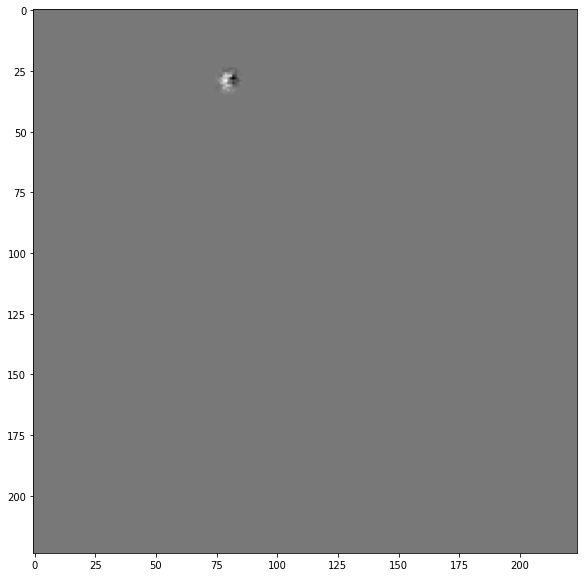

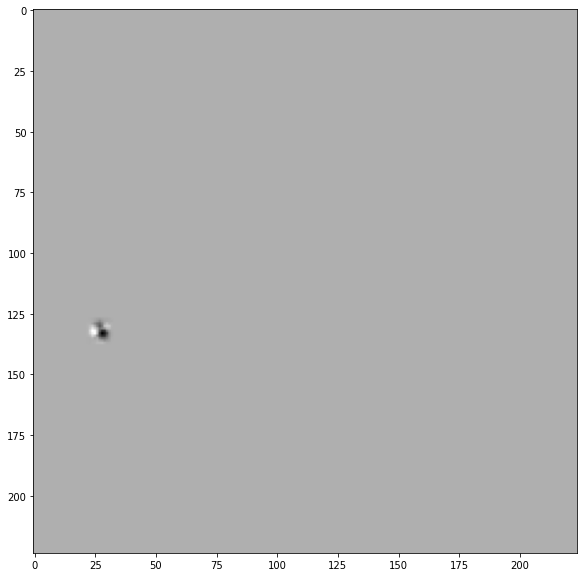

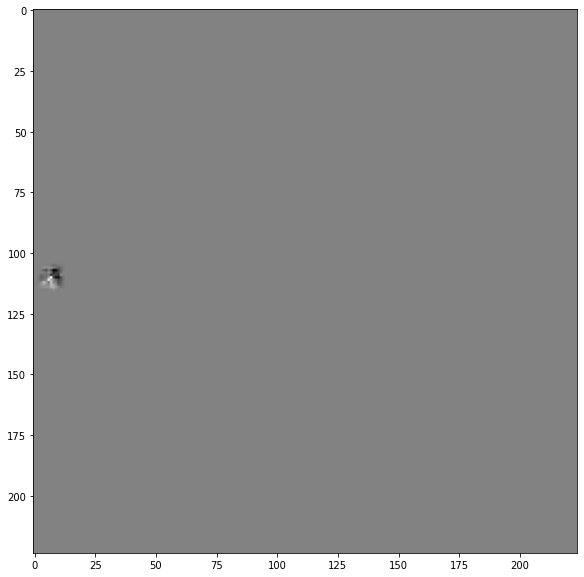

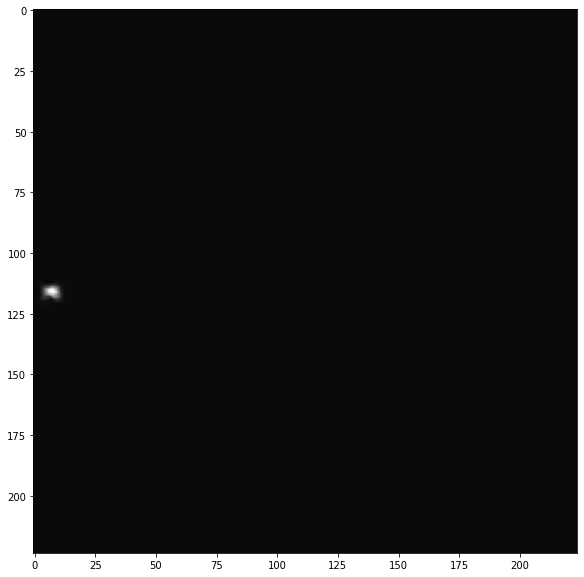

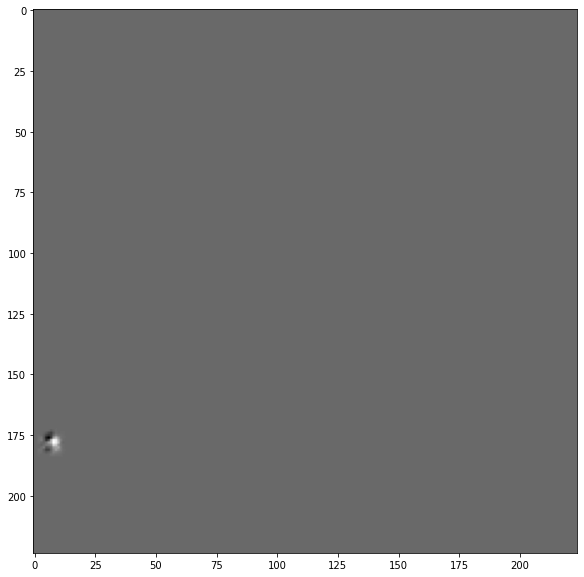

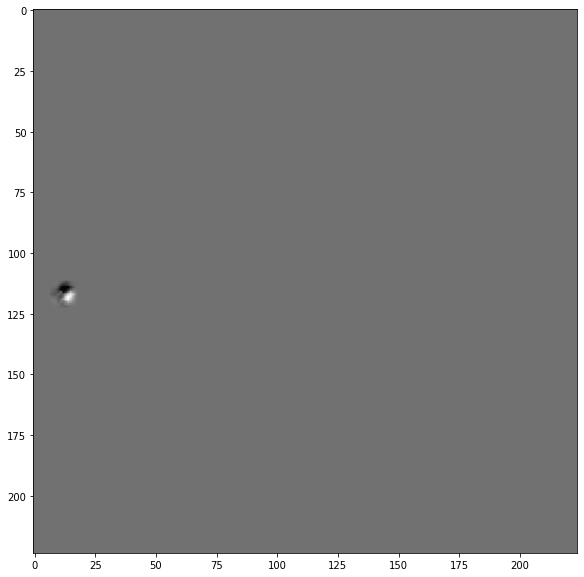

In [48]:
def guided_prop(coord, model,path2image):
  rnd_image = preprocess_image(path2image).to(device)

  def relu_hook_function(module, grad_in, grad_out):
      if isinstance(module, torch.nn.ReLU):
          return (torch.clamp(grad_in[0], min=0.),)

  def prep_output(img_tensor):
    invTrans = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                    std = [ 1., 1., 1. ]),
                            ])
    out = invTrans(img_tensor)[0]
    out = out.detach().numpy().transpose(1, 2, 0)
    return out

  def norm_flat_image(img):
    grads_norm = prep_output(img)
    grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]

    grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
    return grads_norm


  for i, module in enumerate(model.modules()):
      if isinstance(module, torch.nn.ReLU):
          print(model.named_modules())
          module.register_backward_hook(relu_hook_function)

  rnd_image.requires_grad = True

  results = [conv_layers[0](rnd_image)]
  for i in range(1, len(conv_layers)):
      results.append(conv_layers[i](results[-1]))

  ### Random node in CONV 5:
  results[-1][coord].backward()

  grads = rnd_image.grad
  grads = grads.cpu()
  
  
  return norm_flat_image(grads)


#
coord = [(0,22,4,22), (0,3,4,122), (0,4,6,22), (0,42,23,2), (0,41,24,75), (0,18,127,22), (0,0,105,2), (0,3,112,2), (0,24,173,2), (0,118,112,7)] 

for i in coord:
  a = guided_prop(i, model, "/content/drive/MyDrive/inaturalist_12K/val/Animalia/016125d0354a1fc95ed911c85ddec844.jpg")
  plt.figure(figsize =(10,10))
  plt.imshow(a, cmap = "gray")

(0, 22, 4, 22)